In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wfdb # Library untuk data PhysioNet
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import os
from pathlib import Path

In [2]:
def load_nstdb_data(segment_length=1024):
    """
    Mengunduh, membaca, dan memproses data dari MIT-BIH Noise Stress Test DB.
    """
    db_name = 'nstdb'
    # Cek apakah folder data sudah ada, jika tidak, download
    # if not os.path.isdir(db_dir):
    #     print(f"Downloading '{db_name}' database from PhysioNet...")
    #     wfdb.dl_database(db_name, dl_dir='.')
    #     print("Download complete.")
    base_path = Path('nstdb') 
    
    db_dir = base_path 
    if not db_dir.is_dir(): 
        print(f"Database '{db_name}' tidak ditemukan di '{db_dir}'")
        print("Memulai download dari PhysioNet...")
        # Download database ke 'download_dir' yang sudah kita tentukan.
        wfdb.dl_database(db_name, dl_dir=str(base_path))
        print("Download complete.")
    else:
        print(f"Database '{db_name}' sudah ada di lokasi '{db_dir}'.")

    # Rekaman yang mengandung noise signifikan (baseline wander, electrode motion, muscle artifact)
    noisy_records = ['118e06', '118e12', '119e06', '119e12']
    
    X_noisy = []
    y_clean = []

    print("\nProcessing records...")
    for rec_name in noisy_records:
        # Baca rekaman dari direktori database
        record = wfdb.rdrecord(f'{db_dir}/{rec_name}')
        signals = record.p_signal

        # Channel 1 adalah sinyal noisy, Channel 0 adalah sinyal bersih
        noisy_signal = signals[:, 1]
        clean_signal = signals[:, 0]

        # Potong sinyal menjadi segmen-segmen dengan panjang 'segment_length'
        # Kita gunakan overlap (step < segment_length) untuk augmentasi data
        step = 512 
        for i in range(0, len(noisy_signal) - segment_length, step):
            noisy_segment = noisy_signal[i : i + segment_length]
            clean_segment = clean_signal[i : i + segment_length]

            # Normalisasi setiap segmen secara individual
            # Ini penting agar model fokus pada bentuk sinyal, bukan amplitudo absolut
            noisy_segment = (noisy_segment - np.mean(noisy_segment)) / np.std(noisy_segment)
            clean_segment = (clean_segment - np.mean(clean_segment)) / np.std(clean_segment)
            
            X_noisy.append(noisy_segment)
            y_clean.append(clean_segment)
        print(f"  - Record '{rec_name}' processed.")

    # Konversi ke numpy array dan tambahkan dimensi channel
    X = np.array(X_noisy)[..., np.newaxis]
    y = np.array(y_clean)[..., np.newaxis]
    
    return X, y

   
print("Memuat dataset MIT-BIH NSTDB...")
X, y = load_nstdb_data(segment_length=1024)

# Bagi dataset menjadi data training dan validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nDataset berhasil dimuat dan dibagi:")
print(f"  - Data Latih (Train): {X_train.shape}")
print(f"  - Data Validasi (Val): {X_val.shape}")

Memuat dataset MIT-BIH NSTDB...
Database 'nstdb' sudah ada di lokasi 'nstdb'.

Processing records...
  - Record '118e06' processed.
  - Record '118e12' processed.
  - Record '119e06' processed.
  - Record '119e12' processed.

Dataset berhasil dimuat dan dibagi:
  - Data Latih (Train): (4057, 1024, 1)
  - Data Validasi (Val): (1015, 1024, 1)


In [3]:
def build_autoencoder(input_shape=(1024, 1)):
    input_signal = Input(shape=input_shape)
    # Encoder
    x = Conv1D(32, 7, activation='relu', padding='same')(input_signal)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(16, 7, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)
    # Decoder
    x = Conv1D(16, 7, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 7, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, 7, activation='tanh', padding='same')(x)
    autoencoder = Model(input_signal, decoded)
    autoencoder.compile(optimizer='adam', loss='mae')
    return autoencoder

print("\nMembangun model autoencoder...")
model = build_autoencoder()
model.summary()


Membangun model autoencoder...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1024, 32)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 16)           3600      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           

In [7]:
print("\nMemulai pelatihan model dengan data asli...")
history = model.fit(
    X_train, y_train,
    epochs=30, # Mungkin butuh epoch lebih banyak untuk data asli
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('denoise_model.h5', monitor='val_loss', save_best_only=True)
    ]
)

print("\nPelatihan selesai. Model terbaik disimpan sebagai 'denoise_model.h5'")



Memulai pelatihan model dengan data asli...
Epoch 1/30
64/64 [==============================] - 3s 50ms/step - loss: 0.4640 - val_loss: 0.4654
Epoch 2/30
64/64 [==============================] - 3s 47ms/step - loss: 0.4637 - val_loss: 0.4649
Epoch 3/30
64/64 [==============================] - 3s 43ms/step - loss: 0.4630 - val_loss: 0.4640
Epoch 4/30
64/64 [==============================] - 3s 43ms/step - loss: 0.4632 - val_loss: 0.4713
Epoch 5/30
64/64 [==============================] - 3s 42ms/step - loss: 0.4637 - val_loss: 0.4640
Epoch 6/30
64/64 [==============================] - 3s 45ms/step - loss: 0.4625 - val_loss: 0.4715
Epoch 7/30
64/64 [==============================] - 3s 43ms/step - loss: 0.4629 - val_loss: 0.4637
Epoch 8/30
64/64 [==============================] - 3s 43ms/step - loss: 0.4621 - val_loss: 0.4642
Epoch 9/30
64/64 [==============================] - 3s 48ms/step - loss: 0.4626 - val_loss: 0.4656
Epoch 10/30
64/64 [==============================] - 3s 53ms/ste

In [8]:
model.save('denoise_model.keras')


Mengevaluasi hasil pada data validasi...
1/1 [==============================] - 0s 252ms/step


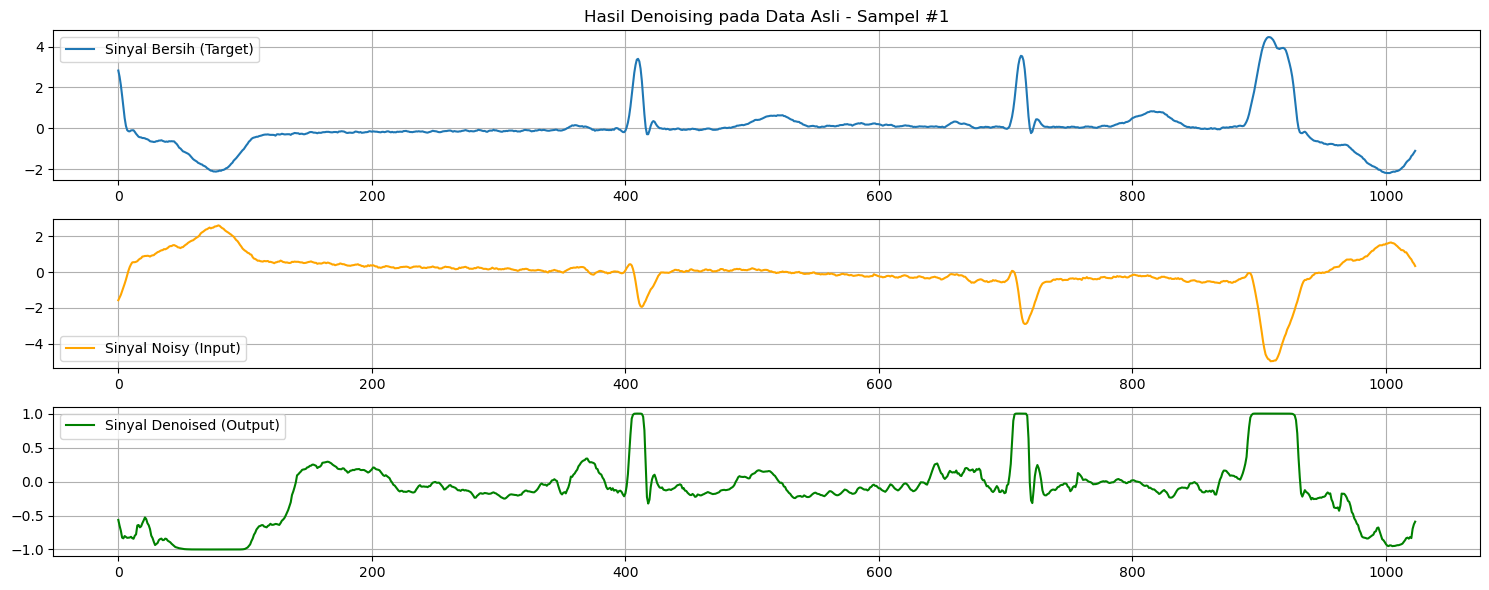

1/1 [==============================] - 0s 22ms/step


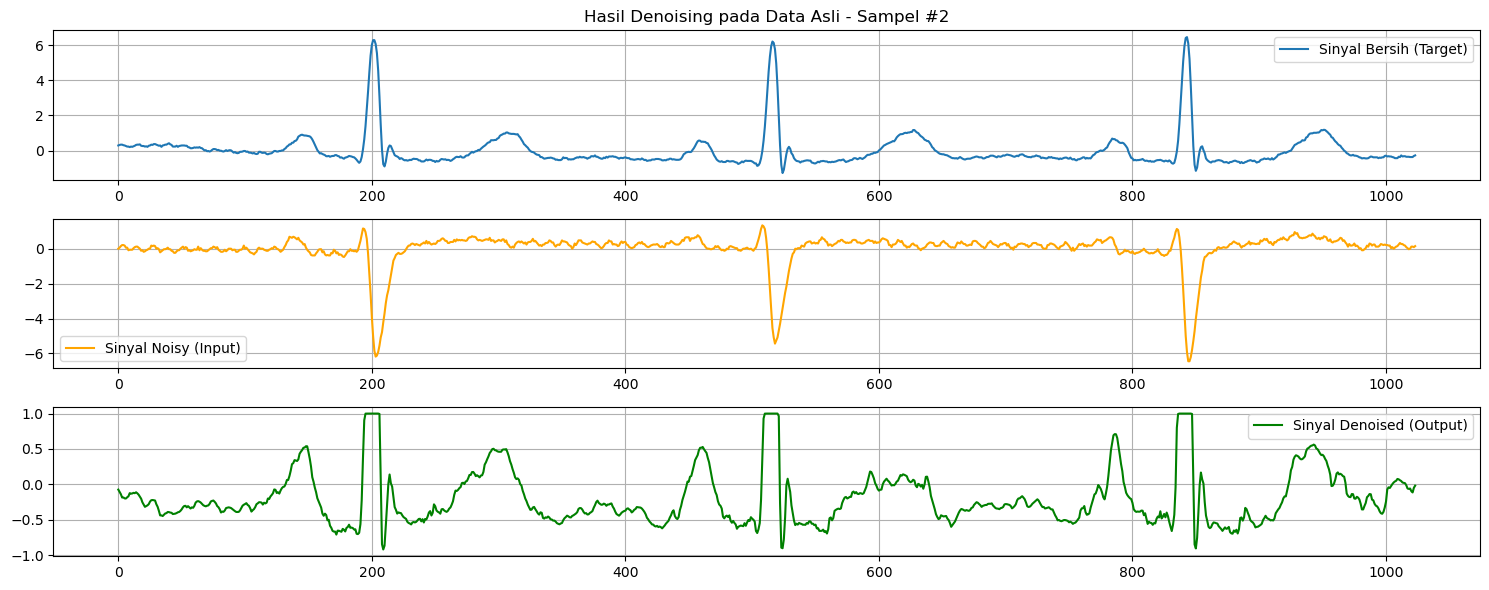

1/1 [==============================] - 0s 15ms/step


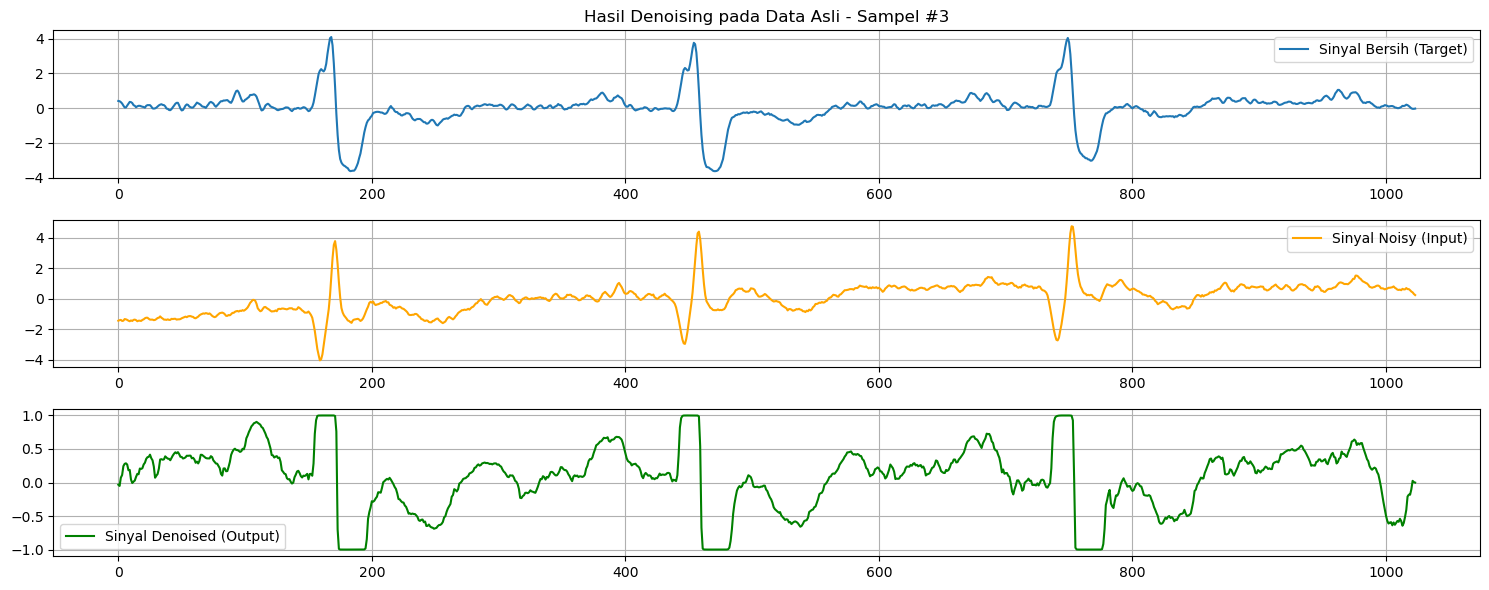

In [9]:
print("\nMengevaluasi hasil pada data validasi...")
n_plots = 3
random_indices = np.random.choice(len(X_val), n_plots)
for i in range(n_plots):
    sample_noisy = X_val[random_indices[i]]
    sample_clean = y_val[random_indices[i]]
    denoised_signal = model.predict(np.expand_dims(sample_noisy, axis=0))

    plt.figure(figsize=(15, 6))
    plt.subplot(3, 1, 1)
    plt.plot(sample_clean.flatten(), label='Sinyal Bersih (Target)')
    plt.title(f'Hasil Denoising pada Data Asli - Sampel #{i+1}')
    plt.legend()
    plt.grid(True)
    plt.subplot(3, 1, 2)
    plt.plot(sample_noisy.flatten(), label='Sinyal Noisy (Input)', color='orange')
    plt.legend()
    plt.grid(True)
    plt.subplot(3, 1, 3)
    plt.plot(denoised_signal.flatten(), label='Sinyal Denoised (Output)', color='green')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
def denoise_ecg_function(raw_ecg_data: list) -> list:
    """
    Menerima data ECG mentah (list), melakukan denoising dengan model,
    dan mengembalikan data yang sudah bersih (list).
    """
    # 1. Load model dari file
    #    Pastikan path 'denoise_model.h5' sesuai dengan lokasi di server lo
    try:
        denoising_model = tf.keras.models.load_model(
            'denoise_model.h5', 
            custom_objects={'mae': 'mae'}
        )
    except Exception as e:
        print(f"Error loading model: {e}")
        return raw_ecg_data

    # 2. Preprocessing (HARUS SAMA PERSIS DENGAN SAAT TRAINING)
    signal_length = 1024 # Samakan dengan input_shape model
    
    # Konversi ke numpy array
    ecg_array = np.array(raw_ecg_data)
    
    # Padding atau trimming agar panjangnya sesuai
    if len(ecg_array) < signal_length:
        # Tambahkan padding jika sinyal terlalu pendek
        padding = np.zeros(signal_length - len(ecg_array))
        ecg_array = np.concatenate([ecg_array, padding])
    elif len(ecg_array) > signal_length:
        # Potong jika sinyal terlalu panjang
        ecg_array = ecg_array[:signal_length]
        
    # Normalisasi
    mean = np.mean(ecg_array)
    std = np.std(ecg_array)
    if std == 0: std = 1 # Hindari pembagian dengan nol
    normalized_ecg = (ecg_array - mean) / std
    
    # Reshape agar sesuai dengan input model (batch, steps, channels)
    input_data = normalized_ecg.reshape(1, signal_length, 1)

    # 3. Lakukan prediksi
    denoised_signal = denoising_model.predict(input_data)

    # 4. Post-processing
    #    a. Flatten hasilnya
    denoised_flat = denoised_signal.flatten()
    
    #    b. Denormalisasi (kembalikan ke skala asli)
    denormalized_ecg = (denoised_flat * std) + mean

    #    c. Konversi kembali ke list python
    return denormalized_ecg.tolist()


In [11]:
print("\nContoh pemakaian fungsi final...")
# Buat data dummy seolah-olah dari request frontend
dummy_noisy_ecg_list = list(X_val[0].flatten())
print(f"Panjang data input: {len(dummy_noisy_ecg_list)}")

cleaned_data = denoise_ecg_function(dummy_noisy_ecg_list)
print(f"Panjang data output: {len(cleaned_data)}")
print("Fungsi final siap digunakan!")


Contoh pemakaian fungsi final...
Panjang data input: 1024
1/1 [==============================] - 0s 215ms/step
Panjang data output: 1024
Fungsi final siap digunakan!
